In [14]:
import sys, os
import glob
import numpy as np
import IPython.display as ipd
import pandas as pd
import glob

import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import librosa

import tensorflow as tf
import six

import plotly
import plotly.plotly as py
from plotly.graph_objs import Surface

%matplotlib inline

In [2]:
#Import .WAV Files
wav_files = glob.glob("../data/sonitrol_audio_*/*.wav")
label_files = glob.glob("../data/sonitrol*/*.xlsx")
print "Num Wav Files: "+str(len(wav_files))

Num Wav Files: 2991


## Overview

Currently tracking the following data issues for our wave files:
- multiple labels for the same audio files (<1%). Skipping these files
- Incorrect label for an audio file (119 not defined for 1 audio file)
- Incorrect size/length of audio file (<2%) - e.g. 1s rather than 5s

~97% can be preserved 

In [ ]:
# Resample Wav Files - Just to Play Around
def resample(sound,sample_rate=8000):
    return signal.resample(sound[1],int(sample_rate/float(sound[0])*sound[1].shape[0])) 

In [ ]:
def get_stats(wav_files):
    dmax = []
    dmin = []
    rates = []
    for rec in wav_files:
        print "Step "+str(len(rates)+1)+" : Loading "+rec
        rate,wave = wavfile.read(rec)
        print "Type: "+str(wave.dtype)
        dmax.append(np.amax(wave))
        dmin.append(np.amin(wave))
        rates.append(rate)
        print "Max: "+str(np.amax(wave))
        print "Min: "+str(np.amin(wave))

    return dmax,dmin,rates

In [ ]:
dmax,dmin,rates = get_stats(wav_files)

In [ ]:
np.savez_compressed("./output/raw.npz",dmax=dmax,rates=rates,dmin=dmin)

In [ ]:
# Play Resampled Sound
new_sample_rate = 8000
resampled = resample(sound,sample_rate=new_sample_rate)
print "New Size: "+str(resampled.shape)
ipd.Audio(resampled,rate=new_sample_rate)

In [ ]:
#Load Data
run = False
if run:
    data = {}
    new_sample_rate=8000
    count = 1
    for x in files:
        name = x.split("/")[-1]
        sound = resample(wavfile.read(x),sample_rate=new_sample_rate)
        data[name] = sound
        print("Loaded Sample: "+str(count))
        count+=1
    np.savez_compressed("./output/data.npz",data=data,sample_rate=new_sample_rate)


In [ ]:
# Load Labels
if run:
    # Retrieve and Save Labels
    all_files = glob.glob("../data/sonitrol_audio_*/*.xlsx")
    df = pd.concat((pd.read_excel(f) for f in all_files))
    
    # FIlter DF
    names = df['file_name'].tolist()
    vals = df['num_label'].tolist()
    
    # Save To Dict
    for idx in range(len(names)):
        labels[names[idx]] = vals[idx]
    print "Saving Labels of Size: "+str(len(labels))
    np.savez_compressed("./output/labels.npz",labels=labels)

In [ ]:
def write_to_csv(wave_files,label_files,orig_size=110250):
    df = pd.concat((pd.read_excel(f) for f in label_files))
    sounds = []
    labels = []
    
    print "Reading Files"
    for wfile in wave_files:
        print "Step: "+str(len(sounds)+1)+" - "+wfile
        key = wfile.split('/')[-1]
        try:
            lab = int(np.unique(df[df['file_name']==key]['num_label']))
        except:
            print "Error - Entry has multiple labels for single entry - skipping"
            continue
        label = 'indistinguishable' if lab<100 else 'distinguishable' 
        sound = resample(wavfile.read(wfile),sample_rate=16000)
        if len(sound)==80000:
            sounds.append(sound)
            labels.append(label)
        else:
            print "Error - File not 5s Long - skipping"
            continue
    
    print "Writing to PD DataFrame"
    df_new = pd.DataFrame(np.stack(sounds,axis=0))
    df_new['label'] = pd.Series(labels,index=df_new.index)
    df_new.to_csv('./output/sonitrol_raw_binary.csv')

In [ ]:
write_to_csv(wav_files,label_files)

## Augment Data

In [3]:
# IMPORT DATA FILE AND AUGMENT
rate, wavdata = wavfile.read(wav_files[0])

In [14]:
def white_noise(data,scale=0.005):
    # Adding white noise 
    wn = np.random.randn(len(data))
    return data + scale*wn

def roll_data(data):
    roll = np.random.randint(0,high=len(data),size=1)
    return np.roll(data,roll)

def stretch_data(data):
    factor = np.random.uniform(0,2,1)
    print factor
    input_length = len(data)
    data = librosa.effects.time_stretch(data, factor)
    if len(data)>input_length:
        data = data[:input_length]
    else:
        data = np.pad(data, (0, max(0, input_length - len(data))), "constant")

    return data

def plot_time_series(data):
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()

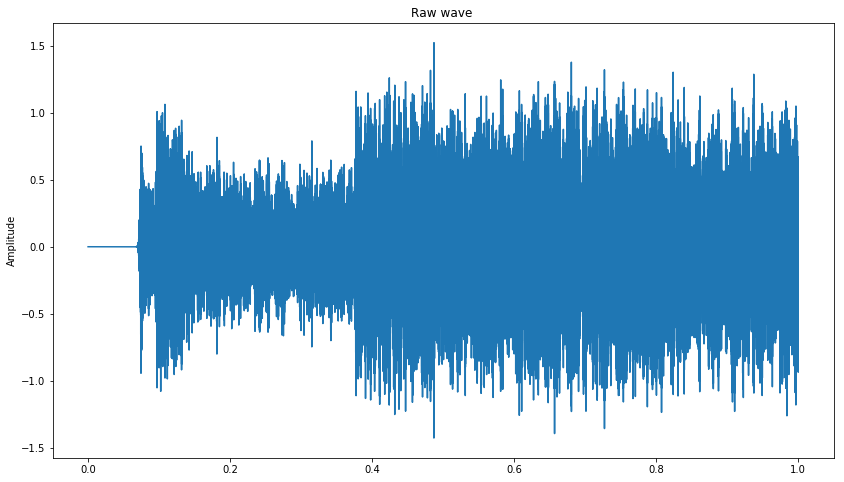

In [15]:
plot_time_series(wavdata)
ipd.Audio(wavdata,rate=rate)

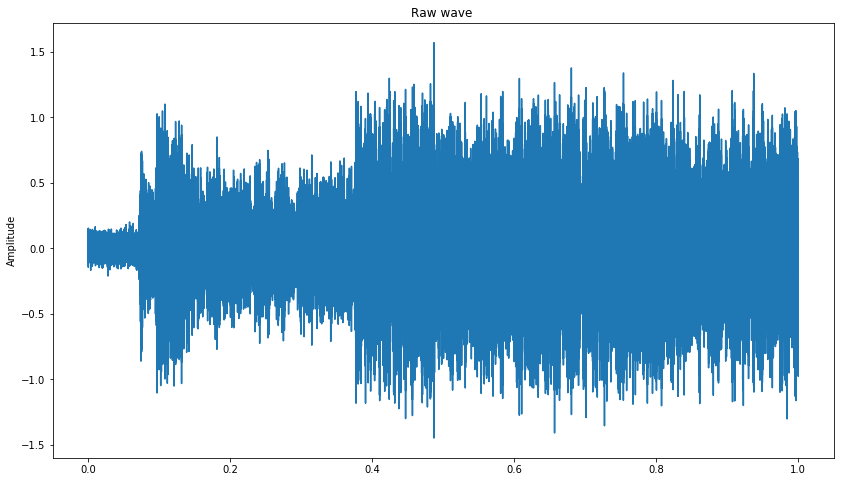

In [16]:
data_wn = white_noise(wavdata,scale=0.05)
plot_time_series(data_wn)
# We limited the amplitude of the noise so we can still hear the word even with the noise, 
#which is the objective
ipd.Audio(data_wn, rate=rate)

[0.76736662]


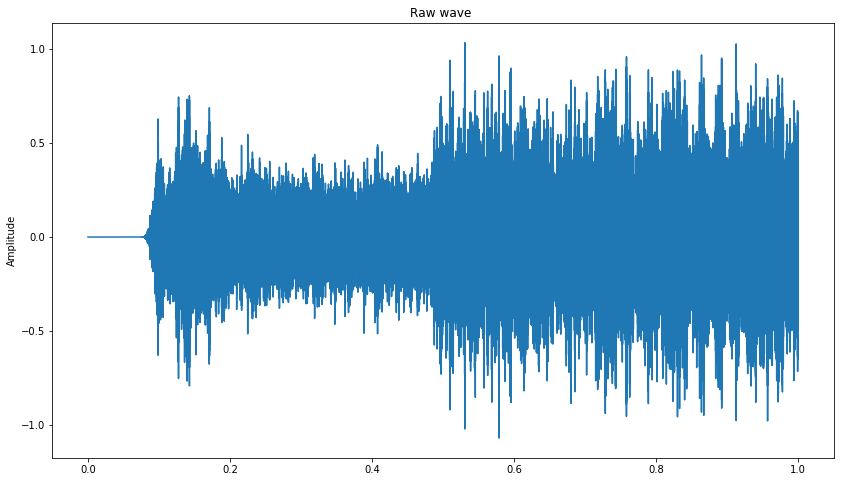

In [18]:
data_stretch = stretch_data(wavdata)
plot_time_series(data_stretch)
ipd.Audio(data_stretch,rate=rate)

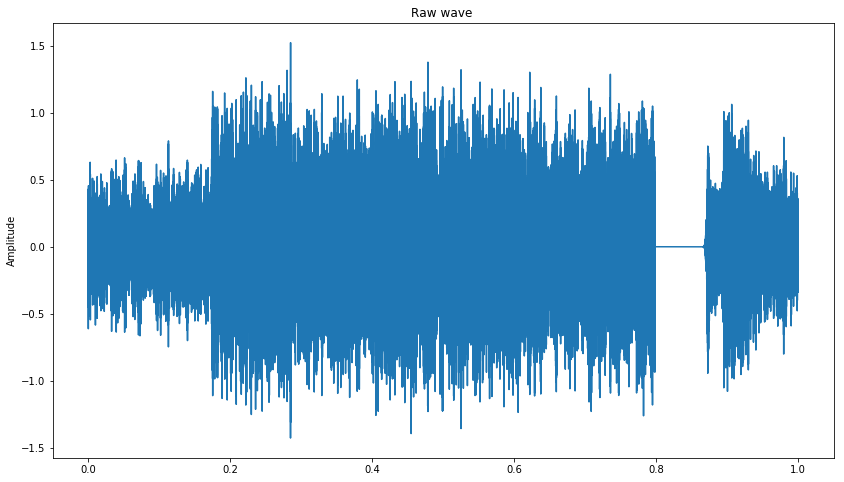

In [12]:
data_roll = roll_data(wavdata)
plot_time_series(data_roll)
ipd.Audio(data_roll, rate=rate)

## Save From Raw mp3 

In [6]:
df = pd.concat((pd.read_excel(f) for f in label_files))

In [20]:
path = df['audio_file'].iloc[0]

In [30]:
#rel_path = "./SonIP_Audio-4278_80-Dec_01_2017-19_39_32.mp3"
#print rel_path
#sound = AudioSegment.from_mp3(rel_path)

In [42]:

for ifile in wav_files:
    print ifile
    res = os.system('afinfo '+ifile)
    print res

../data/sonitrol_audio_01/Audio-1002_126-Dec_06_2017-22_56_51.wav
32512
../data/sonitrol_audio_01/Audio-1002_96-Dec_02_2017-23_07_39.wav
32512
../data/sonitrol_audio_01/Audio-1017_1-Dec_04_2017-20_45_58.wav
32512
../data/sonitrol_audio_01/Audio-1017_32-Dec_03_2017-15_48_15.wav
32512
../data/sonitrol_audio_01/Audio-1021_80-Dec_05_2017-20_03_18.wav
32512
../data/sonitrol_audio_01/Audio-1021_80-Dec_07_2017-15_20_59.wav
32512
../data/sonitrol_audio_01/Audio-1049_4-Dec_03_2017-10_24_07.wav
32512
../data/sonitrol_audio_01/Audio-1060_4-Dec_04_2017-21_23_54.wav
32512
../data/sonitrol_audio_01/Audio-1064_126-Dec_02_2017-05_38_06.wav
32512
../data/sonitrol_audio_01/Audio-1071_29-Dec_06_2017-10_15_08.wav
32512
../data/sonitrol_audio_01/Audio-1081_13-Dec_04_2017-08_42_16.wav
32512
../data/sonitrol_audio_01/Audio-1089_27-Dec_02_2017-16_00_16.wav
32512
../data/sonitrol_audio_01/Audio-1097_13-Dec_04_2017-23_22_52.wav
32512
../data/sonitrol_audio_01/Audio-1103_32-Dec_02_2017-13_31_30.wav
32512
../data

32512
../data/sonitrol_audio_01/Audio-1889_6-Nov_30_2017-21_25_18.wav
32512
../data/sonitrol_audio_01/Audio-1889_6-Nov_30_2017-21_34_02.wav
32512
../data/sonitrol_audio_01/Audio-1894_26-Dec_03_2017-01_59_11.wav
32512
../data/sonitrol_audio_01/Audio-1903_125-Dec_05_2017-01_14_13.wav
32512
../data/sonitrol_audio_01/Audio-1903_125-Dec_06_2017-00_51_22.wav
32512
../data/sonitrol_audio_01/Audio-1915_127-Dec_06_2017-21_54_38.wav
32512
../data/sonitrol_audio_01/Audio-1915_127-Dec_06_2017-22_03_26.wav
32512
../data/sonitrol_audio_01/Audio-1915_127-Dec_06_2017-22_07_22.wav
32512
../data/sonitrol_audio_01/Audio-1943_117-Dec_07_2017-04_06_57.wav
32512
../data/sonitrol_audio_01/Audio-1945_103-Dec_04_2017-10_10_35.wav
32512
../data/sonitrol_audio_01/Audio-1945_103-Dec_04_2017-10_30_37.wav
32512
../data/sonitrol_audio_01/Audio-1972_1-Dec_01_2017-02_40_27.wav
32512
../data/sonitrol_audio_01/Audio-1972_6-Dec_06_2017-18_53_01.wav
32512
../data/sonitrol_audio_01/Audio-1972_6-Dec_07_2017-06_29_03.wav
325

32512
../data/sonitrol_audio_01/Audio-2473_6-Dec_05_2017-12_18_02.wav
32512
../data/sonitrol_audio_01/Audio-2473_6-Dec_06_2017-15_31_01.wav
32512
../data/sonitrol_audio_01/Audio-2489_4-Dec_03_2017-07_57_50.wav
32512
../data/sonitrol_audio_01/Audio-2497_6-Dec_05_2017-13_17_45.wav
32512
../data/sonitrol_audio_01/Audio-2500_122-Dec_07_2017-17_13_37.wav
32512
../data/sonitrol_audio_01/Audio-2501_96-Dec_02_2017-13_39_03.wav
32512
../data/sonitrol_audio_01/Audio-2501_96-Dec_02_2017-13_39_28.wav
32512
../data/sonitrol_audio_01/Audio-2501_96-Dec_04_2017-16_39_46.wav
32512
../data/sonitrol_audio_01/Audio-2501_96-Dec_06_2017-17_23_13.wav
32512
../data/sonitrol_audio_01/Audio-2501_96-Dec_06_2017-17_24_15.wav
32512
../data/sonitrol_audio_01/Audio-2501_96-Dec_06_2017-17_26_16.wav
32512
../data/sonitrol_audio_01/Audio-2501_96-Dec_06_2017-21_07_28.wav
32512
../data/sonitrol_audio_01/Audio-2501_96-Dec_06_2017-21_08_46.wav
32512
../data/sonitrol_audio_01/Audio-2501_96-Dec_06_2017-21_09_28.wav
32512
../

32512
../data/sonitrol_audio_01/Audio-3332_85-Dec_04_2017-02_01_37.wav
32512
../data/sonitrol_audio_01/Audio-3332_85-Dec_04_2017-04_01_47.wav
32512
../data/sonitrol_audio_01/Audio-3332_85-Dec_05_2017-20_03_09.wav
32512
../data/sonitrol_audio_01/Audio-3332_85-Nov_30_2017-22_02_04.wav
32512
../data/sonitrol_audio_01/Audio-3336_104-Dec_03_2017-16_24_04.wav
32512
../data/sonitrol_audio_01/Audio-3337_20-Nov_30_2017-21_51_13.wav
32512
../data/sonitrol_audio_01/Audio-3347_103-Dec_06_2017-22_22_02.wav
32512
../data/sonitrol_audio_01/Audio-3395_112-Dec_01_2017-18_19_54.wav
32512
../data/sonitrol_audio_01/Audio-3395_112-Dec_04_2017-19_38_55.wav
32512
../data/sonitrol_audio_01/Audio-3426_32-Dec_05_2017-23_58_11.wav
32512
../data/sonitrol_audio_01/Audio-3449_20-Dec_04_2017-22_28_18.wav
32512
../data/sonitrol_audio_01/Audio-3449_20-Dec_04_2017-22_37_01.wav
32512
../data/sonitrol_audio_01/Audio-3449_20-Dec_04_2017-22_37_50.wav
32512
../data/sonitrol_audio_01/Audio-3449_20-Dec_04_2017-22_40_28.wav
32

32512
../data/sonitrol_audio_01/Audio-4223_80-Dec_06_2017-16_32_33.wav
32512
../data/sonitrol_audio_01/Audio-4223_80-Dec_06_2017-20_08_44.wav
32512
../data/sonitrol_audio_01/Audio-4223_80-Nov_30_2017-18_40_59.wav
32512
../data/sonitrol_audio_01/Audio-4228_97-Dec_05_2017-16_04_25.wav
32512
../data/sonitrol_audio_01/Audio-4237_80-Dec_03_2017-17_03_04.wav
32512
../data/sonitrol_audio_01/Audio-4278_80-Dec_01_2017-01_57_04.wav
32512
../data/sonitrol_audio_01/Audio-4278_80-Dec_01_2017-19_39_32.wav
32512
../data/sonitrol_audio_01/Audio-4278_80-Dec_05_2017-19_27_22.wav
32512
../data/sonitrol_audio_01/Audio-4278_80-Nov_30_2017-19_08_55.wav
32512
../data/sonitrol_audio_01/Audio-4278_80-Nov_30_2017-19_19_36.wav
32512
../data/sonitrol_audio_01/Audio-4278_80-Nov_30_2017-21_07_47.wav
32512
../data/sonitrol_audio_01/Audio-4278_80-Nov_30_2017-21_28_53.wav
32512
../data/sonitrol_audio_01/Audio-4282_18-Dec_03_2017-14_51_32.wav
32512
../data/sonitrol_audio_01/Audio-4294_3-Nov_30_2017-20_49_17.wav
32512
.

32512
../data/sonitrol_audio_01/Audio-5272_126-Dec_04_2017-00_22_31.wav
32512
../data/sonitrol_audio_01/Audio-5296_105-Nov_30_2017-18_53_26.wav
32512
../data/sonitrol_audio_01/Audio-5308_96-Dec_05_2017-16_41_41.wav
32512
../data/sonitrol_audio_01/Audio-5348_92-Dec_05_2017-19_21_47.wav
32512
../data/sonitrol_audio_01/Audio-5364_246-Dec_02_2017-00_37_45.wav
32512
../data/sonitrol_audio_01/Audio-5369_122-Dec_02_2017-19_26_40.wav
32512
../data/sonitrol_audio_01/Audio-5369_122-Dec_03_2017-09_12_51.wav
32512
../data/sonitrol_audio_01/Audio-5369_122-Dec_03_2017-10_33_11.wav
32512
../data/sonitrol_audio_01/Audio-5371_21-Dec_03_2017-01_52_38.wav
32512
../data/sonitrol_audio_01/Audio-5390_122-Dec_02_2017-22_58_06.wav
32512
../data/sonitrol_audio_01/Audio-5390_122-Dec_02_2017-22_59_18.wav
32512
../data/sonitrol_audio_01/Audio-5390_143-Nov_30_2017-18_32_13.wav
32512
../data/sonitrol_audio_01/Audio-5449_13-Dec_06_2017-01_11_52.wav
32512
../data/sonitrol_audio_01/Audio-5477_1-Nov_30_2017-20_08_44.wa

../data/sonitrol_audio_01/Audio-6689_96-Dec_07_2017-17_33_33.wav
32512
../data/sonitrol_audio_01/Audio-6711_104-Dec_03_2017-16_27_52.wav
32512
../data/sonitrol_audio_01/Audio-6711_104-Dec_05_2017-19_46_29.wav
32512
../data/sonitrol_audio_01/Audio-6718_126-Dec_03_2017-23_36_50.wav
32512
../data/sonitrol_audio_01/Audio-6752_1-Dec_06_2017-20_17_36.wav
32512
../data/sonitrol_audio_01/Audio-6755_96-Dec_04_2017-21_43_47.wav
32512
../data/sonitrol_audio_01/Audio-6771_20-Dec_01_2017-09_35_51.wav
32512
../data/sonitrol_audio_01/Audio-6771_20-Dec_01_2017-16_09_32.wav
32512
../data/sonitrol_audio_01/Audio-6773_20-Dec_04_2017-20_03_35.wav
32512
../data/sonitrol_audio_01/Audio-6776_117-Dec_03_2017-22_22_12.wav
32512
../data/sonitrol_audio_01/Audio-6777_126-Dec_05_2017-21_34_01.wav
32512
../data/sonitrol_audio_01/Audio-6779_80-Dec_05_2017-21_01_28.wav
32512
../data/sonitrol_audio_01/Audio-6779_80-Dec_05_2017-21_02_05.wav
32512
../data/sonitrol_audio_01/Audio-6782_126-Dec_03_2017-00_23_59.wav
32512
.

32512
../data/sonitrol_audio_01/Audio-8307_1-Dec_06_2017-21_06_16.wav
32512
../data/sonitrol_audio_01/Audio-8324_108-Dec_06_2017-20_46_42.wav
32512
../data/sonitrol_audio_01/Audio-8327_117-Dec_02_2017-22_00_47.wav
32512
../data/sonitrol_audio_01/Audio-8350_1-Dec_01_2017-22_43_47.wav
32512
../data/sonitrol_audio_01/Audio-8350_1-Dec_04_2017-20_47_12.wav
32512
../data/sonitrol_audio_01/Audio-8350_1-Dec_04_2017-21_34_13.wav
32512
../data/sonitrol_audio_01/Audio-8360_97-Dec_01_2017-01_02_13.wav
32512
../data/sonitrol_audio_01/Audio-8368_65-Dec_04_2017-08_30_49.wav
32512
../data/sonitrol_audio_01/Audio-8368_65-Dec_05_2017-03_43_57.wav
32512
../data/sonitrol_audio_01/Audio-8380_65-Dec_02_2017-15_03_16.wav
32512
../data/sonitrol_audio_01/Audio-8391_92-Dec_02_2017-07_17_10.wav
32512
../data/sonitrol_audio_01/Audio-8391_92-Dec_07_2017-03_19_28.wav
32512
../data/sonitrol_audio_01/Audio-8484_4-Dec_07_2017-02_43_33.wav
32512
../data/sonitrol_audio_01/Audio-8490_104-Dec_06_2017-09_46_33.wav
32512
..

32512
../data/sonitrol_audio_02/Audio-1539_80-Dec_13_2017-23_16_11.wav
32512
../data/sonitrol_audio_02/Audio-1539_80-Dec_14_2017-05_06_21.wav
32512
../data/sonitrol_audio_02/Audio-1551_118-Dec_10_2017-09_01_38.wav
32512
../data/sonitrol_audio_02/Audio-1555_126-Dec_09_2017-23_46_42.wav
32512
../data/sonitrol_audio_02/Audio-1556_80-Dec_13_2017-20_34_00.wav
32512
../data/sonitrol_audio_02/Audio-1572_80-Dec_09_2017-17_45_14.wav
32512
../data/sonitrol_audio_02/Audio-1572_80-Dec_09_2017-17_48_33.wav
32512
../data/sonitrol_audio_02/Audio-1572_80-Dec_09_2017-17_53_05.wav
32512
../data/sonitrol_audio_02/Audio-1573_32-Dec_14_2017-17_06_16.wav
32512
../data/sonitrol_audio_02/Audio-1584_92-Dec_07_2017-22_52_09.wav
32512
../data/sonitrol_audio_02/Audio-1598_80-Dec_11_2017-18_29_03.wav
32512
../data/sonitrol_audio_02/Audio-1618_80-Dec_08_2017-17_26_34.wav
32512
../data/sonitrol_audio_02/Audio-1620_33-Dec_08_2017-18_22_55.wav
32512
../data/sonitrol_audio_02/Audio-1643_80-Dec_08_2017-03_52_44.wav
3251

32512
../data/sonitrol_audio_02/Audio-2108_80-Dec_07_2017-22_37_55.wav
32512
../data/sonitrol_audio_02/Audio-2108_80-Dec_10_2017-06_31_21.wav
32512
../data/sonitrol_audio_02/Audio-2108_80-Dec_13_2017-20_01_36.wav
32512
../data/sonitrol_audio_02/Audio-2114_80-Dec_07_2017-19_23_48.wav
32512
../data/sonitrol_audio_02/Audio-2118_120-Dec_10_2017-21_55_48.wav
32512
../data/sonitrol_audio_02/Audio-2130_126-Dec_12_2017-17_03_14.wav
32512
../data/sonitrol_audio_02/Audio-2131_244-Dec_08_2017-18_44_21.wav
32512
../data/sonitrol_audio_02/Audio-2131_244-Dec_11_2017-21_46_59.wav
32512
../data/sonitrol_audio_02/Audio-2131_244-Dec_13_2017-05_37_17.wav
32512
../data/sonitrol_audio_02/Audio-2133_80-Dec_11_2017-00_01_52.wav
32512
../data/sonitrol_audio_02/Audio-2133_80-Dec_11_2017-23_44_39.wav
32512
../data/sonitrol_audio_02/Audio-2135_80-Dec_08_2017-16_20_22.wav
32512
../data/sonitrol_audio_02/Audio-2135_80-Dec_08_2017-16_30_23.wav
32512
../data/sonitrol_audio_02/Audio-2135_80-Dec_09_2017-15_30_22.wav
3

32512
../data/sonitrol_audio_02/Audio-3017_15-Dec_09_2017-12_35_08.wav
32512
../data/sonitrol_audio_02/Audio-3017_15-Dec_10_2017-13_20_41.wav
32512
../data/sonitrol_audio_02/Audio-3017_15-Dec_12_2017-22_30_36.wav
32512
../data/sonitrol_audio_02/Audio-3077_32-Dec_08_2017-05_28_03.wav
32512
../data/sonitrol_audio_02/Audio-3080_13-Dec_10_2017-15_10_47.wav
32512
../data/sonitrol_audio_02/Audio-3080_97-Dec_11_2017-18_24_48.wav
32512
../data/sonitrol_audio_02/Audio-3080_97-Dec_11_2017-20_45_10.wav
32512
../data/sonitrol_audio_02/Audio-3086_80-Dec_13_2017-17_39_56.wav
32512
../data/sonitrol_audio_02/Audio-3086_80-Dec_13_2017-18_33_36.wav
32512
../data/sonitrol_audio_02/Audio-3091_13-Dec_11_2017-19_09_20.wav
32512
../data/sonitrol_audio_02/Audio-3091_80-Dec_07_2017-20_52_44.wav
32512
../data/sonitrol_audio_02/Audio-3091_80-Dec_12_2017-15_01_35.wav
32512
../data/sonitrol_audio_02/Audio-3092_117-Dec_09_2017-15_48_49.wav
32512
../data/sonitrol_audio_02/Audio-3094_13-Dec_11_2017-01_40_53.wav
32512

32512
../data/sonitrol_audio_02/Audio-3969_85-Dec_10_2017-22_42_23.wav
32512
../data/sonitrol_audio_02/Audio-3969_85-Dec_10_2017-23_59_17.wav
32512
../data/sonitrol_audio_02/Audio-3969_85-Dec_11_2017-04_03_24.wav
32512
../data/sonitrol_audio_02/Audio-3974_85-Dec_10_2017-16_14_30.wav
32512
../data/sonitrol_audio_02/Audio-3998_80-Dec_08_2017-19_43_43.wav
32512
../data/sonitrol_audio_02/Audio-3998_80-Dec_08_2017-20_39_35.wav
32512
../data/sonitrol_audio_02/Audio-3998_80-Dec_08_2017-22_37_53.wav
32512
../data/sonitrol_audio_02/Audio-3998_80-Dec_10_2017-18_13_36.wav
32512
../data/sonitrol_audio_02/Audio-3998_80-Dec_10_2017-20_22_47.wav
32512
../data/sonitrol_audio_02/Audio-4002_22-Dec_12_2017-00_37_07.wav
32512
../data/sonitrol_audio_02/Audio-4017_2-Dec_09_2017-16_07_35.wav
32512
../data/sonitrol_audio_02/Audio-4022_85-Dec_13_2017-04_45_54.wav
32512
../data/sonitrol_audio_02/Audio-4025_32-Dec_09_2017-04_26_55.wav
32512
../data/sonitrol_audio_02/Audio-4030_85-Dec_11_2017-18_11_49.wav
32512
.

32512
../data/sonitrol_audio_02/Audio-4622_125-Dec_08_2017-00_20_37.wav
32512
../data/sonitrol_audio_02/Audio-4622_125-Dec_08_2017-00_24_25.wav
32512
../data/sonitrol_audio_02/Audio-4639_11-Dec_12_2017-22_03_45.wav
32512
../data/sonitrol_audio_02/Audio-4653_85-Dec_09_2017-17_37_36.wav
32512
../data/sonitrol_audio_02/Audio-4653_85-Dec_09_2017-18_31_43.wav
32512
../data/sonitrol_audio_02/Audio-4653_85-Dec_09_2017-21_08_00.wav
32512
../data/sonitrol_audio_02/Audio-4653_85-Dec_09_2017-22_05_30.wav
32512
../data/sonitrol_audio_02/Audio-4658_85-Dec_08_2017-20_52_21.wav
32512
../data/sonitrol_audio_02/Audio-4662_85-Dec_10_2017-18_25_28.wav
32512
../data/sonitrol_audio_02/Audio-4675_3-Dec_13_2017-18_59_30.wav
32512
../data/sonitrol_audio_02/Audio-4710_3-Dec_09_2017-02_53_12.wav
32512
../data/sonitrol_audio_02/Audio-4710_3-Dec_10_2017-02_36_57.wav
32512
../data/sonitrol_audio_02/Audio-4710_3-Dec_12_2017-00_30_15.wav
32512
../data/sonitrol_audio_02/Audio-4733_85-Dec_10_2017-15_25_17.wav
32512
..

32512
../data/sonitrol_audio_02/Audio-6130_126-Dec_12_2017-18_33_55.wav
32512
../data/sonitrol_audio_02/Audio-6138_126-Dec_07_2017-21_06_51.wav
32512
../data/sonitrol_audio_02/Audio-6138_126-Dec_07_2017-21_07_46.wav
32512
../data/sonitrol_audio_02/Audio-6138_126-Dec_11_2017-19_55_42.wav
32512
../data/sonitrol_audio_02/Audio-6142_80-Dec_08_2017-15_44_08.wav
32512
../data/sonitrol_audio_02/Audio-6142_80-Dec_08_2017-19_20_30.wav
32512
../data/sonitrol_audio_02/Audio-6142_80-Dec_11_2017-15_51_38.wav
32512
../data/sonitrol_audio_02/Audio-6142_80-Dec_11_2017-17_25_05.wav
32512
../data/sonitrol_audio_02/Audio-6142_80-Dec_13_2017-16_17_00.wav
32512
../data/sonitrol_audio_02/Audio-6142_80-Dec_13_2017-19_04_21.wav
32512
../data/sonitrol_audio_02/Audio-6157_121-Dec_08_2017-19_20_09.wav
32512
../data/sonitrol_audio_02/Audio-6170_80-Dec_12_2017-23_00_00.wav
32512
../data/sonitrol_audio_02/Audio-6179_96-Dec_11_2017-23_03_46.wav
32512
../data/sonitrol_audio_02/Audio-6184_1-Dec_13_2017-02_03_49.wav
32

32512
../data/sonitrol_audio_02/Audio-7507_104-Dec_12_2017-23_55_13.wav
32512
../data/sonitrol_audio_02/Audio-7514_22-Dec_12_2017-22_06_38.wav
32512
../data/sonitrol_audio_02/Audio-7532_105-Dec_10_2017-02_07_56.wav
32512
../data/sonitrol_audio_02/Audio-7535_85-Dec_09_2017-16_33_04.wav
32512
../data/sonitrol_audio_02/Audio-7539_8-Dec_10_2017-16_23_52.wav
32512
../data/sonitrol_audio_02/Audio-7555_96-Dec_11_2017-03_49_50.wav
32512
../data/sonitrol_audio_02/Audio-7583_85-Dec_08_2017-00_06_01.wav
32512
../data/sonitrol_audio_02/Audio-7583_85-Dec_09_2017-00_19_20.wav
32512
../data/sonitrol_audio_02/Audio-7583_85-Dec_09_2017-00_45_51.wav
32512
../data/sonitrol_audio_02/Audio-7583_85-Dec_13_2017-00_09_52.wav
32512
../data/sonitrol_audio_02/Audio-7583_85-Dec_14_2017-01_08_18.wav
32512
../data/sonitrol_audio_02/Audio-7609_1-Dec_10_2017-04_26_22.wav
32512
../data/sonitrol_audio_02/Audio-7611_104-Dec_12_2017-02_15_20.wav
32512
../data/sonitrol_audio_02/Audio-7632_85-Dec_08_2017-17_06_34.wav
32512

32512
../data/sonitrol_audio_02/Audio-8862_104-Dec_12_2017-18_12_46.wav
32512
../data/sonitrol_audio_02/Audio-8872_126-Dec_13_2017-09_53_19.wav
32512
../data/sonitrol_audio_02/Audio-8883_125-Dec_10_2017-03_30_58.wav
32512
../data/sonitrol_audio_02/Audio-8883_125-Dec_11_2017-19_30_55.wav
32512
../data/sonitrol_audio_02/Audio-8890_119-Dec_12_2017-21_34_08.wav
32512
../data/sonitrol_audio_02/Audio-8891_97-Dec_09_2017-18_59_30.wav
32512
../data/sonitrol_audio_02/Audio-8891_97-Dec_10_2017-22_41_07.wav
32512
../data/sonitrol_audio_02/Audio-8893_119-Dec_12_2017-17_03_27.wav
32512
../data/sonitrol_audio_02/Audio-8893_119-Dec_13_2017-03_01_04.wav
32512
../data/sonitrol_audio_02/Audio-8906_108-Dec_11_2017-21_33_49.wav
32512
../data/sonitrol_audio_02/Audio-8916_20-Dec_10_2017-10_47_21.wav
32512
../data/sonitrol_audio_02/Audio-8920_20-Dec_11_2017-22_50_16.wav
32512
../data/sonitrol_audio_02/Audio-8925_104-Dec_09_2017-17_18_18.wav
32512
../data/sonitrol_audio_02/Audio-8933_112-Dec_10_2017-22_46_16.

32512
../data/sonitrol_audio_03/Audio-1647_80-Dec_15_2017-17_28_52.wav
32512
../data/sonitrol_audio_03/Audio-1647_80-Dec_21_2017-17_32_12.wav
32512
../data/sonitrol_audio_03/Audio-1653_80-Dec_16_2017-19_27_22.wav
32512
../data/sonitrol_audio_03/Audio-1653_80-Dec_16_2017-19_39_01.wav
32512
../data/sonitrol_audio_03/Audio-1654_30-Dec_16_2017-11_10_04.wav
32512
../data/sonitrol_audio_03/Audio-1654_30-Dec_16_2017-11_25_29.wav
32512
../data/sonitrol_audio_03/Audio-1666_27-Dec_19_2017-22_19_47.wav
32512
../data/sonitrol_audio_03/Audio-1666_27-Dec_19_2017-23_38_23.wav
32512
../data/sonitrol_audio_03/Audio-1681_80-Dec_14_2017-18_34_23.wav
32512
../data/sonitrol_audio_03/Audio-1681_80-Dec_17_2017-23_52_26.wav
32512
../data/sonitrol_audio_03/Audio-1686_3-Dec_19_2017-21_54_47.wav
32512
../data/sonitrol_audio_03/Audio-1699_80-Dec_17_2017-15_51_12.wav
32512
../data/sonitrol_audio_03/Audio-1700_118-Dec_15_2017-14_10_43.wav
32512
../data/sonitrol_audio_03/Audio-1719_122-Dec_18_2017-17_51_55.wav
32512

32512
../data/sonitrol_audio_03/Audio-2201_80-Dec_20_2017-18_16_32.wav
32512
../data/sonitrol_audio_03/Audio-2211_6-Dec_16_2017-20_41_06.wav
32512
../data/sonitrol_audio_03/Audio-2211_6-Dec_16_2017-23_54_56.wav
32512
../data/sonitrol_audio_03/Audio-2211_6-Dec_17_2017-16_51_16.wav
32512
../data/sonitrol_audio_03/Audio-2214_118-Dec_17_2017-14_42_25.wav
32512
../data/sonitrol_audio_03/Audio-2216_80-Dec_16_2017-18_41_41.wav
32512
../data/sonitrol_audio_03/Audio-2228_80-Dec_19_2017-23_58_05.wav
32512
../data/sonitrol_audio_03/Audio-2228_80-Dec_20_2017-00_47_09.wav
32512
../data/sonitrol_audio_03/Audio-2240_20-Dec_16_2017-15_39_20.wav
32512
../data/sonitrol_audio_03/Audio-2240_20-Dec_16_2017-18_12_18.wav
32512
../data/sonitrol_audio_03/Audio-2249_112-Dec_16_2017-08_52_51.wav
32512
../data/sonitrol_audio_03/Audio-2261_80-Dec_15_2017-00_17_46.wav
32512
../data/sonitrol_audio_03/Audio-2269_6-Dec_17_2017-00_35_10.wav
32512
../data/sonitrol_audio_03/Audio-2278_96-Dec_16_2017-22_04_53.wav
32512
..

32512
../data/sonitrol_audio_03/Audio-301_14-Dec_19_2017-20_45_52.wav
32512
../data/sonitrol_audio_03/Audio-3021_105-Dec_17_2017-05_24_20.wav
32512
../data/sonitrol_audio_03/Audio-3051_80-Dec_19_2017-00_49_44.wav
32512
../data/sonitrol_audio_03/Audio-3061_33-Dec_15_2017-23_49_43.wav
32512
../data/sonitrol_audio_03/Audio-3065_119-Dec_18_2017-21_54_13.wav
32512
../data/sonitrol_audio_03/Audio-3086_80-Dec_21_2017-17_54_59.wav
32512
../data/sonitrol_audio_03/Audio-3091_80-Dec_15_2017-22_50_23.wav
32512
../data/sonitrol_audio_03/Audio-3091_80-Dec_15_2017-23_15_43.wav
32512
../data/sonitrol_audio_03/Audio-3091_80-Dec_18_2017-15_01_19.wav
32512
../data/sonitrol_audio_03/Audio-3091_80-Dec_19_2017-15_17_34.wav
32512
../data/sonitrol_audio_03/Audio-3091_80-Dec_21_2017-15_18_53.wav
32512
../data/sonitrol_audio_03/Audio-3093_117-Dec_17_2017-16_11_14.wav
32512
../data/sonitrol_audio_03/Audio-3094_13-Dec_17_2017-05_21_41.wav
32512
../data/sonitrol_audio_03/Audio-3135_14-Dec_15_2017-20_11_18.wav
3251

32512
../data/sonitrol_audio_03/Audio-4047_80-Dec_16_2017-18_51_44.wav
32512
../data/sonitrol_audio_03/Audio-4057_80-Dec_14_2017-20_18_05.wav
32512
../data/sonitrol_audio_03/Audio-4057_80-Dec_16_2017-21_01_09.wav
32512
../data/sonitrol_audio_03/Audio-4057_80-Dec_19_2017-17_15_32.wav
32512
../data/sonitrol_audio_03/Audio-4077_85-Dec_19_2017-18_38_19.wav
32512
../data/sonitrol_audio_03/Audio-4078_85-Dec_14_2017-21_58_17.wav
32512
../data/sonitrol_audio_03/Audio-4078_85-Dec_20_2017-19_05_45.wav
32512
../data/sonitrol_audio_03/Audio-4078_85-Dec_21_2017-17_48_06.wav
32512
../data/sonitrol_audio_03/Audio-4094_85-Dec_19_2017-16_07_23.wav
32512
../data/sonitrol_audio_03/Audio-4106_80-Dec_16_2017-22_57_49.wav
32512
../data/sonitrol_audio_03/Audio-4106_80-Dec_18_2017-04_15_24.wav
32512
../data/sonitrol_audio_03/Audio-4112_80-Dec_15_2017-20_03_05.wav
32512
../data/sonitrol_audio_03/Audio-4112_80-Dec_19_2017-19_03_02.wav
32512
../data/sonitrol_audio_03/Audio-4114_80-Dec_18_2017-18_48_57.wav
32512


32512
../data/sonitrol_audio_03/Audio-4942_16-Dec_17_2017-14_07_50.wav
32512
../data/sonitrol_audio_03/Audio-4942_16-Dec_19_2017-15_53_21.wav
32512
../data/sonitrol_audio_03/Audio-4961_1-Dec_18_2017-17_39_53.wav
32512
../data/sonitrol_audio_03/Audio-4974_3-Dec_18_2017-19_11_04.wav
32512
../data/sonitrol_audio_03/Audio-4981_96-Dec_18_2017-02_54_49.wav
32512
../data/sonitrol_audio_03/Audio-4988_5-Dec_16_2017-12_22_06.wav
32512
../data/sonitrol_audio_03/Audio-5005_25-Dec_20_2017-08_26_18.wav
32512
../data/sonitrol_audio_03/Audio-5005_3-Dec_19_2017-18_29_59.wav
32512
../data/sonitrol_audio_03/Audio-5012_3-Dec_17_2017-15_32_11.wav
32512
../data/sonitrol_audio_03/Audio-5016_105-Dec_14_2017-22_07_42.wav
32512
../data/sonitrol_audio_03/Audio-5018_15-Dec_18_2017-21_32_51.wav
32512
../data/sonitrol_audio_03/Audio-5018_15-Dec_19_2017-17_57_22.wav
32512
../data/sonitrol_audio_03/Audio-5026_96-Dec_19_2017-19_04_33.wav
32512
../data/sonitrol_audio_03/Audio-5028_96-Dec_18_2017-23_24_23.wav
32512
../d

32512
../data/sonitrol_audio_03/Audio-6534_120-Dec_15_2017-03_27_51.wav
32512
../data/sonitrol_audio_03/Audio-6541_105-Dec_16_2017-19_41_19.wav
32512
../data/sonitrol_audio_03/Audio-6541_29-Dec_17_2017-00_23_42.wav
32512
../data/sonitrol_audio_03/Audio-6604_80-Dec_16_2017-17_07_52.wav
32512
../data/sonitrol_audio_03/Audio-6604_80-Dec_16_2017-17_10_41.wav
32512
../data/sonitrol_audio_03/Audio-6609_104-Dec_18_2017-02_52_17.wav
32512
../data/sonitrol_audio_03/Audio-6609_104-Dec_18_2017-03_52_48.wav
32512
../data/sonitrol_audio_03/Audio-6609_104-Dec_20_2017-04_51_06.wav
32512
../data/sonitrol_audio_03/Audio-6612_121-Dec_20_2017-22_36_33.wav
32512
../data/sonitrol_audio_03/Audio-6613_104-Dec_16_2017-22_35_24.wav
32512
../data/sonitrol_audio_03/Audio-6626_20-Dec_16_2017-19_50_12.wav
32512
../data/sonitrol_audio_03/Audio-6626_20-Dec_17_2017-17_18_35.wav
32512
../data/sonitrol_audio_03/Audio-6629_80-Dec_15_2017-02_28_36.wav
32512
../data/sonitrol_audio_03/Audio-6629_80-Dec_19_2017-06_41_32.wav

32512
../data/sonitrol_audio_03/Audio-7676_97-Dec_19_2017-02_29_06.wav
32512
../data/sonitrol_audio_03/Audio-7682_8-Dec_16_2017-09_48_08.wav
32512
../data/sonitrol_audio_03/Audio-7682_8-Dec_17_2017-02_57_36.wav
32512
../data/sonitrol_audio_03/Audio-7682_8-Dec_17_2017-16_46_16.wav
32512
../data/sonitrol_audio_03/Audio-7682_8-Dec_17_2017-17_50_22.wav
32512
../data/sonitrol_audio_03/Audio-7684_85-Dec_18_2017-06_40_10.wav
32512
../data/sonitrol_audio_03/Audio-7696_85-Dec_17_2017-06_18_51.wav
32512
../data/sonitrol_audio_03/Audio-7699_125-Dec_17_2017-17_39_47.wav
32512
../data/sonitrol_audio_03/Audio-7701_105-Dec_17_2017-04_55_35.wav
32512
../data/sonitrol_audio_03/Audio-7705_33-Dec_17_2017-02_36_19.wav
32512
../data/sonitrol_audio_03/Audio-7706_14-Dec_20_2017-20_01_15.wav
32512
../data/sonitrol_audio_03/Audio-7712_5-Dec_18_2017-17_43_51.wav
32512
../data/sonitrol_audio_03/Audio-7713_21-Dec_17_2017-13_45_04.wav
32512
../data/sonitrol_audio_03/Audio-7733_104-Dec_15_2017-22_54_43.wav
32512
..

32512
../data/sonitrol_audio_03/Audio-8967_33-Dec_20_2017-21_42_01.wav
32512
../data/sonitrol_audio_03/Audio-8980_97-Dec_17_2017-13_01_27.wav
32512
../data/sonitrol_audio_03/Audio-9097_32-Dec_16_2017-16_10_19.wav
32512
../data/sonitrol_audio_03/Audio-9141_100-Dec_17_2017-18_41_31.wav
32512
../data/sonitrol_audio_03/Audio-9141_100-Dec_17_2017-18_43_50.wav
32512
../data/sonitrol_audio_03/Audio-9214_8-Dec_16_2017-12_29_06.wav
32512
../data/sonitrol_audio_03/Audio-9229_104-Dec_20_2017-18_16_34.wav
32512
../data/sonitrol_audio_03/Audio-9243_104-Dec_19_2017-23_12_13.wav
32512
../data/sonitrol_audio_03/Audio-924_21-Dec_16_2017-01_14_04.wav
32512
../data/sonitrol_audio_03/Audio-924_21-Dec_16_2017-02_20_16.wav
32512
../data/sonitrol_audio_03/Audio-9262_104-Dec_16_2017-01_11_11.wav
32512
../data/sonitrol_audio_03/Audio-9262_104-Dec_16_2017-20_57_25.wav
32512
../data/sonitrol_audio_03/Audio-9262_104-Dec_16_2017-20_58_41.wav
32512
../data/sonitrol_audio_03/Audio-9262_104-Dec_16_2017-21_00_05.wav
3

## Visualize

In [3]:
import models.research.audioset.vggish_params as vggish_params
from models.research.audioset.vggish_input  import wavfile_to_examples, waveform_to_examples
from models.research.audioset.mel_features import log_mel_spectrogram

In [4]:
mel_gram = wavfile_to_examples(wav_files[0])
print mel_gram.shape

(5, 96, 64)


In [34]:
def surface_plot(spect):
    # Get slices
    slice1 = spect[0]
    slice2 = spect[1]-5
    slice3 = spect[2]-10
    slice4 = spect[3]-15
    slice5 = spect[4]-20
    
    xs = np.linspace(0,0.96,len(slice1))
    
    # Plot slices
    py.iplot([dict(x=xs,z=slice1, type='surface')],filename='basic')
    return

In [35]:
plotly.tools.set_credentials_file(username='jtutmaher', api_key='wYUcaukDoPQDpvkAwG58')
plotly.tools.set_config_file(world_readable=True,sharing='public')
surface_plot(mel_gram)

In [33]:
import plotly.graph_objs as go

rate,wave = wavfile.read(wav_files[0])

trun = int(len(wave)/5.0)

xs = np.linspace(0,1,trun)

data = [go.Scatter(x=xs,y=wave[:trun])]
py.iplot(data)